In [55]:
import json
import os
import sys

import mne
import numpy as np
import pandas as pd

import pac

import matplotlib.pyplot as plt



suffix = '_1_200_double'
gamma = [1, 200]
beta = [1, 50]

groups = ['PD Med Off', 'PD Med On', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']

In [11]:
def create_tasks_df(ds_path=None):
    if ds_path is None:
        with open('config.json') as f:
            config = json.load(f)
        base_path = config['BASE_PATH']
        ds_path = os.path.join(base_path, 'ds003490-download')

    df = pd.read_csv(os.path.join(ds_path, 'participants.tsv'), sep="\t")
    tasks = []

    for _, participant in df.iterrows():
        if participant.Group == 'PD':
            sessions = [(1, 1 * (participant.sess1_Med == 'ON')),
                        (2, 1 * (participant.sess2_Med == 'ON'))]
        else:
            sessions = [(1, 2)]

        for sess, pd_drug_type in sessions:
            participant_tasks = {}
            participant_tasks['participant_id'] = participant['participant_id']
            participant_tasks['pd_drug_type'] = pd_drug_type
            participant_tasks['isMale'] = participant['sex'] == 'Male'
            participant_tasks['age'] = participant['age']
            participant_tasks['dir'] = os.path.join(ds_path, participant['participant_id'], f'ses-{sess:02}', 'eeg', )
            participant_tasks[
                'file'] = f'{participant["participant_id"]}_ses-{sess:02}_eeg_{participant["participant_id"]}_ses-{sess:02}_task-Rest_eeg.mat'
            participant_tasks['file_formatter'] = f'{participant["participant_id"]}_ses-{sess:02}_task-Rest_{{}}'
            participant_tasks['path'] = os.path.join(
                participant_tasks['dir'], participant_tasks['file'])

            tasks.append(participant_tasks)

    tasks_df = pd.DataFrame(tasks)

    return tasks_df


def _test_tasks_df(tasks_df, i=0):
    task = tasks_df.iloc[i]

    assert os.path.exists(task.path)

    ds = sio.loadmat(task.path)

    ds['data'] = ds['EEG']

    nbchan = ds['data'][0, 0]['nbchan'][0, 0]  # .dtype
    Fs = ds['data'][0, 0]['srate'][0, 0]
    times = ds['data'][0, 0]['times']
    data = ds['data'][0, 0]['data']

    dtypes = [k for k in ds['data'][0, 0]['event'].dtype.names]
    events = pd.DataFrame([{n: event[n].item() if event[n].size > 0 else None for n in dtypes}
                           for event in ds['data'][0, 0]['event'][0]])

    electrodes = pd.read_csv(os.path.join(
        task['dir'], task['file_formatter'].format('electrodes.tsv')), sep='\t')

    reject = ds['data'][0, 0]['reject']

    print(events)


In [ ]:
tasks_df = create_tasks_df()
sub_stims = np.zeros((74, 192))

i = 0
for task in tasks_df.iloc:
    raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], 'pre_' + task['file_formatter'].format('eeg_double.set')),
                                      preload=True, verbose=0)
    events, event_dict = mne.events_from_annotations(raw, verbose=0)
    stims = events[:, 2][(events[:, 2] > 4) * (events[:, 2] < 8)]
    if stims.shape[0] < 192:
        print(task)
        print(stims.shape)
        continue
    sub_stims[i, :] = stims[:192] - 5
    i += 1
    print(i, stims.shape)
    
#     break

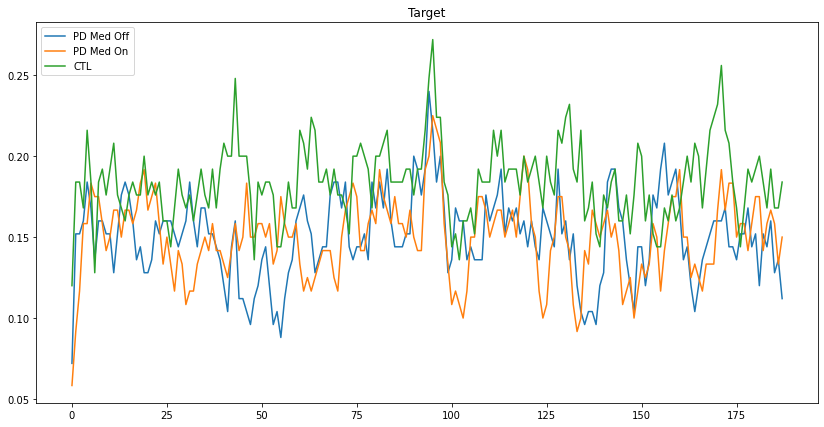

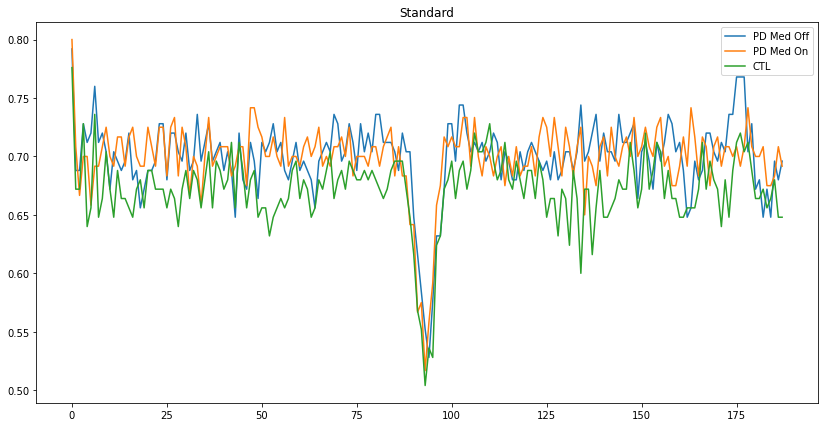

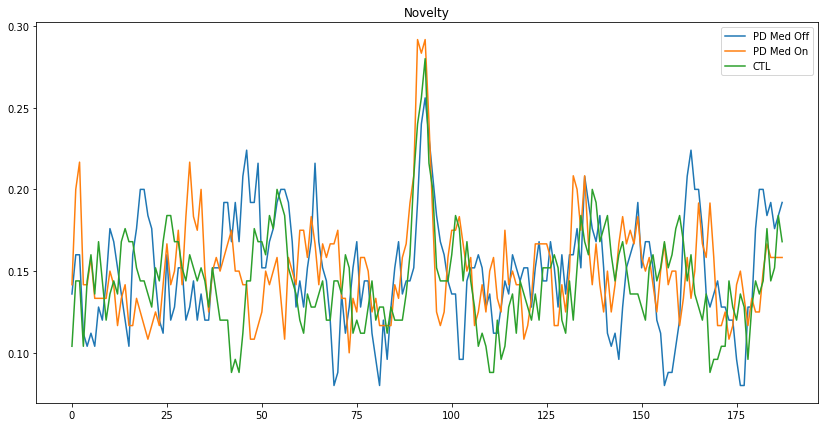

In [74]:
N = 5
conv_sub_stims = np.zeros((74, 192 - N + 1))
window = np.ones((N, )) / N

for k in range(3):
    for i in range(sub_stims.shape[0]):
        conv_sub_stims[i] = np.convolve(sub_stims[i] == k, window, 'valid')

    plt.figure(figsize=(14, 7))
    for i in range(3):
        plt.plot(conv_sub_stims[tasks_df.pd_drug_type[tasks_df.index != 14] == i].
                 mean(axis=0), label=groups[i])
    plt.title(event_types[k])
    plt.legend()
    plt.show()

In [69]:
conv_sub_stims

array([[1.2, 1. , 1. , ..., 1.2, 1.4, 1.2],
       [1.2, 1. , 1. , ..., 1.2, 1.4, 1.4],
       [1.2, 1. , 0.8, ..., 1.2, 1.2, 1.2],
       ...,
       [1.2, 1. , 1. , ..., 1. , 1. , 1.2],
       [1. , 0.8, 0.8, ..., 0.8, 0.8, 0.8],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])